In [ ]:
!pip install dtcwt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.8 MB/s eta 0:00:00
  Created wheel for dtcwt: filename=dtcwt-0.14.0-py3-none-any.whl size=89102 sha256=62fff71794b5f38986b6783ed3ca346e9578abb097a696ede59b1b665871f6b6
  Stored in directory: /root/.cache/pip/wheels/9b/bb/8a/a308db74860f29b02ce5fd707d584a9cf36c583bada376909b
Successfully built dtcwt
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import dtcwt
print(dtcwt.__version__)

0.14.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/ColabUploads/sub_Dresden/sub_Dresden"))

['.DS_Store', 'Samsung_L74wide', 'Sony_DSC_H50', 'Olympus_mju_1050SW', 'rollei_RCP_7325XS', 'Canon_Ixus55_0', 'Pentax_OptioA40', 'Ricoh_GX100', 'Agfa_Sensor530s_0', 'Praktica_DCZ59', 'Nikon_D70', 'Nikon_CoolPixS710_0', 'Sony_DSC_W170', 'Pentax_OptioW60', 'Sony_DSC_T77', 'Samsung_NV15', 'Casio_EX_Z150_0', 'Panasonic_DMC_FZ50', 'Canon_PowerShotA640', 'Agfa_Sensor505-x_0', 'Agfa_DC-504_0', 'Nikon_D200', 'Agfa_DC-830i_0', 'Kodak_M1063_0', 'FujiFilm_FinePixJ50_0', 'Canon_Ixus70_0', 'Agfa_DC-733s']


In [ ]:
# DTCWT

Extracting fingerprints...


100%|██████████| 130/130 [06:16<00:00,  2.90s/it]


Performing 8385 comparisons...


100%|██████████| 130/130 [00:10<00:00, 12.56it/s]


Average Fingerprint Extraction Time: 2.8828 sec per image
Average Comparison Time: 0.0012 sec per comparison


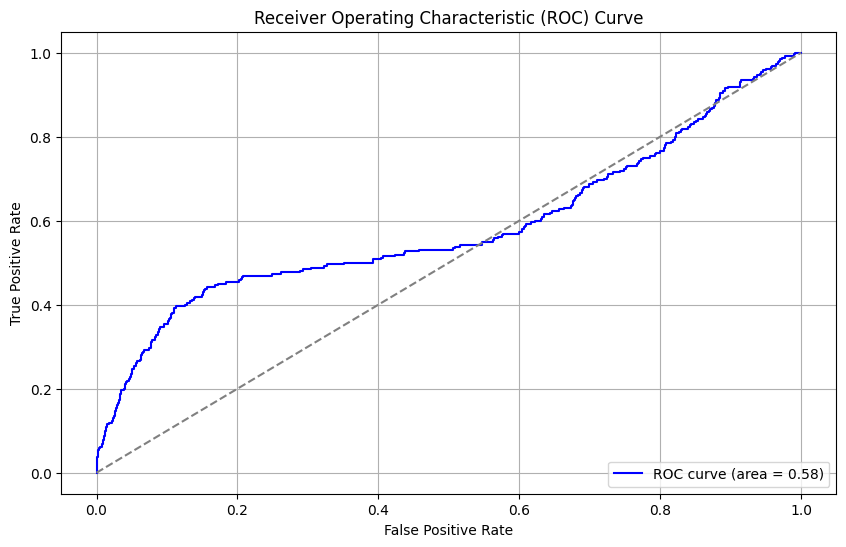

AUC: 0.5835
TPR (Optimal): 0.4423
TNR (Optimal): 0.8436
Optimal Threshold: 0.9069
TPR (TNR = 0.99): 0.0769
Threshold (TNR = 0.99): 0.9786
Total execution time: 387.28s


In [ ]:

import argparse
import json
import math
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
from pathlib import Path
from sklearn.metrics import roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.signal import wiener
from scipy.ndimage import uniform_filter
from numpy.fft import fft2, ifft2
import dtcwt

#spns_dir = Path("/content/sub_Dresden/sub_Dresden")
spns_dir = Path("/content/drive/MyDrive/ColabUploads/sub_Dresden/sub_Dresden")


memory = joblib.Memory(location='cachedir', verbose=0)

@dataclass
class ImageData:
    image_id: str
    device_id: str

    def spn_path(self):
        device_spns_folder = spns_dir / self.device_id
        return device_spns_folder / (self.image_id + ".JPG")

def read_test_into_image_data_list():
    image_data_list = []

    for device_folder in spns_dir.iterdir():
        if device_folder.is_dir():
            device_id = device_folder.name
            for image_file in device_folder.glob("*.JPG"):
                # Skip hidden files (those that start with a dot)
                if image_file.name.startswith("."):
                    continue
                image_id = image_file.stem
                image_data_list.append(ImageData(image_id=image_id, device_id=device_id))

    return image_data_list


def wiener_adaptive(x: np.ndarray, noise_var: float, **kwargs) -> np.ndarray:

    window_size_list = list(kwargs.pop('window_size_list', [3, 5, 7, 9]))

    if x.ndim == 2:
        energy = x.real ** 2 + x.imag**2
        avg_win_energy = np.zeros(x.shape + (len(window_size_list),))

        for window_idx, window_size in enumerate(window_size_list):
            avg_win_energy[:, :, window_idx] = uniform_filter(energy, window_size, mode='constant')

        coef_var = threshold(avg_win_energy, noise_var)
        coef_var_min = np.min(avg_win_energy, axis=2)
        x = x * noise_var / (coef_var_min + noise_var)

    elif x.ndim == 3:
        out = np.zeros_like(x)
        for ch in range(x.shape[2]):
            out[:, :, ch] = wiener_adaptive(x[:, :, ch], noise_var, **kwargs)
        x = out

    return x


def wiener_dft(im: np.ndarray, sigma: float) -> np.ndarray:

    noise_var = sigma ** 2
    h, w = im.shape

    im_noise_fft = fft2(im)
    im_noise_fft_mag = np.abs(im_noise_fft / (h * w) ** .5)
    im_noise_fft_mag_noise = wiener_adaptive(im_noise_fft_mag, noise_var)

    zeros_y, zeros_x = np.nonzero(im_noise_fft_mag == 0)
    im_noise_fft_mag[zeros_y, zeros_x] = 1
    im_noise_fft_mag_noise[zeros_y, zeros_x] = 0

    im_noise_fft_filt = im_noise_fft * im_noise_fft_mag_noise / im_noise_fft_mag
    im_noise_filt = np.real(ifft2(im_noise_fft_filt))

    return im_noise_filt.astype(np.float32)

def threshold(wlet_coeff_energy_avg: np.ndarray, noise_var: float) -> np.ndarray:

    res = wlet_coeff_energy_avg - noise_var
    return (res + np.abs(res)) / 2

@memory.cache
def get_wave_components(image_path: Path, crop_size=1024, noise_var: float = 1.8**2):

    start_time = time.time()

    # Load and crop the image
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    left = max((width - crop_size) // 2, 0)
    top = max((height - crop_size) // 2, 0)
    right = left + crop_size
    bottom = top + crop_size
    cropped_image = image.crop((left, top, right, bottom))
    image_array = np.array(cropped_image, dtype=np.float32)  # shape: (H, W, 3)

    # Prepare per-channel residuals
    residual_channels = []

    for c in range(3):
        channel = image_array[:, :, c]

        transform = dtcwt.Transform2d()
        coeffs = transform.forward(channel, nlevels=4)


        filtered_highpasses = []
        for level in range(4):
          for direction in range(6):
            coeffs.highpasses[level][:,:,direction] = wiener_adaptive(coeffs.highpasses[level][:,:,direction], noise_var)


        residual = transform.inverse(coeffs)
        residual_channels.append(residual)

    residual_stack = np.stack(residual_channels, axis=2)  # (H, W, 3)
    fingerprint = image_array - residual_stack

    fingerprint = 0.2989 * residual_stack[:, :, 0] + \
                    0.5870 * residual_stack[:, :, 1] + \
                    0.1140 * residual_stack[:, :, 2]

    # Apply optional DFT-based Wiener filter in image domain
    #fingerprint = wiener_dft(residual_gray, np.std(residual_gray)).flatten()
    fingerprint = fingerprint.flatten()

    extraction_time = time.time() - start_time
    return fingerprint, extraction_time



@memory.cache
def calculate_cosine_similarity(a_path: Path, b_path: Path):

    a_pc, a_time = get_wave_components(a_path)
    b_pc, b_time = get_wave_components(b_path)

    start_time = time.time()
    similarity = 1 - cosine(a_pc.ravel(), b_pc.ravel())
    end_time = time.time()

    comparison_time = end_time - start_time
    extraction_time = a_time + b_time  # Sum of both extraction times

    return similarity, extraction_time, comparison_time


def calculate_scores():
    image_data_list = read_test_into_image_data_list()

    fingerprint_dict = {}
    extraction_times = []

    print("Extracting fingerprints...")
    for image_data in tqdm(image_data_list):
        fingerprint, extraction_time = get_wave_components(image_data.spn_path())
        fingerprint_dict[(image_data.device_id, image_data.image_id)] = fingerprint
        extraction_times.append(extraction_time)

    rows = []
    total_comparisons = len(image_data_list) * (len(image_data_list) - 1) // 2
    print(f"Performing {total_comparisons} comparisons...")

    for i, img_data_a in enumerate(tqdm(image_data_list)):
        for img_data_b in image_data_list[i + 1:]:
            fingerprint_a = fingerprint_dict[(img_data_a.device_id, img_data_a.image_id)]
            fingerprint_b = fingerprint_dict[(img_data_b.device_id, img_data_b.image_id)]

            start_time = time.time()
            similarity = 1 - cosine(fingerprint_a, fingerprint_b)
            comparison_time = time.time() - start_time

            rows.append({
                'device_id_1': img_data_a.device_id,
                'image_id_1': img_data_a.image_id,
                'device_id_2': img_data_b.device_id,
                'image_id_2': img_data_b.image_id,
                'similarity': similarity,
                'comparison_time': comparison_time
            })

    df = pd.DataFrame(rows)
    df['avg_extraction_time_per_image'] = np.mean(extraction_times)
    return df


def plot_roc_curve(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def calculate_metrics(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Optimal threshold based on Youden's index (maximizing TPR - FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    tp = ((y_scores >= optimal_threshold) & (y_true == 1)).sum()
    fp = ((y_scores >= optimal_threshold) & (y_true == 0)).sum()
    fn = ((y_scores < optimal_threshold) & (y_true == 1)).sum()
    tn = ((y_scores < optimal_threshold) & (y_true == 0)).sum()

    tpr_optimal = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr_optimal = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Calculate TPR when TNR = 0.99
    desired_tnr = 0.99
    desired_fpr = 1 - desired_tnr

    # Find the closest FPR value to the desired FPR
    idx_tnr = np.where(fpr <= desired_fpr)[0]
    if len(idx_tnr) > 0:
        idx_tnr = idx_tnr[-1]  # Last index where FPR <= desired_fpr
        tpr_at_tnr_99 = tpr[idx_tnr]
        threshold_at_tnr_99 = thresholds[idx_tnr]
    else:
        tpr_at_tnr_99 = 0.0
        threshold_at_tnr_99 = None

    metrics = {
        'AUC': roc_auc,
        'TPR (Optimal)': tpr_optimal,
        'TNR (Optimal)': tnr_optimal,
        'Optimal Threshold': optimal_threshold,
        'TPR (TNR = 0.99)': tpr_at_tnr_99,
        'Threshold (TNR = 0.99)': threshold_at_tnr_99,
    }
    return metrics


def main():
    start = time.time()
    df = calculate_scores()

    avg_extraction_time = df['avg_extraction_time_per_image'].iloc[0]
    avg_comparison_time = df['comparison_time'].mean()

    print(f"Average Fingerprint Extraction Time: {avg_extraction_time:.4f} sec per image")
    print(f"Average Comparison Time: {avg_comparison_time:.4f} sec per comparison")

    plot_roc_curve(df)
    metrics = calculate_metrics(df)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

    end = time.time()
    print(f'Total execution time: {end - start:.2f}s')



if __name__ == '__main__':
    main()


In [ ]:
# DTCWT with artifact removal

Extracting fingerprints...


100%|██████████| 130/130 [07:03<00:00,  3.26s/it]


Performing 8385 comparisons...


100%|██████████| 130/130 [00:10<00:00, 12.63it/s]


Average Fingerprint Extraction Time: 3.2475 sec per image
Average Comparison Time: 0.0012 sec per comparison


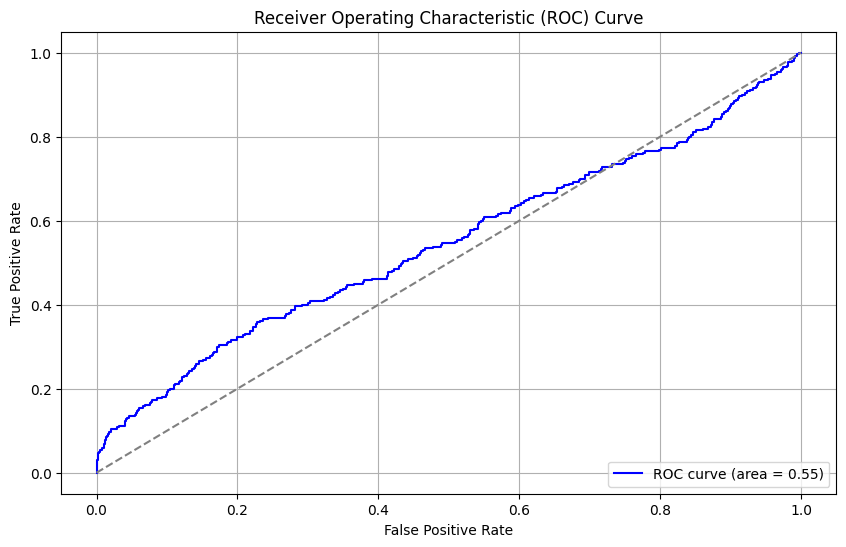

AUC: 0.5453
TPR (Optimal): 0.3038
TNR (Optimal): 0.8261
Optimal Threshold: 0.2876
TPR (TNR = 0.99): 0.0577
Threshold (TNR = 0.99): 0.5329
Total execution time: 434.18s


In [ ]:

import argparse
import json
import math
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
from pathlib import Path
from sklearn.metrics import roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.signal import wiener
from scipy.ndimage import uniform_filter
from numpy.fft import fft2, ifft2
import dtcwt

#spns_dir = Path("/content/sub_Dresden/sub_Dresden")
spns_dir = Path("/content/drive/MyDrive/ColabUploads/sub_Dresden/sub_Dresden")


memory = joblib.Memory(location='cachedir', verbose=0)

@dataclass
class ImageData:
    image_id: str
    device_id: str

    def spn_path(self):
        device_spns_folder = spns_dir / self.device_id
        return device_spns_folder / (self.image_id + ".JPG")

def read_test_into_image_data_list():
    image_data_list = []

    for device_folder in spns_dir.iterdir():
        if device_folder.is_dir():
            device_id = device_folder.name
            for image_file in device_folder.glob("*.JPG"):
                # Skip hidden files (those that start with a dot)
                if image_file.name.startswith("."):
                    continue
                image_id = image_file.stem
                image_data_list.append(ImageData(image_id=image_id, device_id=device_id))

    return image_data_list


def wiener_adaptive(x: np.ndarray, noise_var: float, **kwargs) -> np.ndarray:

    window_size_list = list(kwargs.pop('window_size_list', [3, 5, 7, 9]))

    if x.ndim == 2:
        energy = x.real ** 2 + x.imag**2
        avg_win_energy = np.zeros(x.shape + (len(window_size_list),))

        for window_idx, window_size in enumerate(window_size_list):
            avg_win_energy[:, :, window_idx] = uniform_filter(energy, window_size, mode='constant')

        coef_var = threshold(avg_win_energy, noise_var)
        coef_var_min = np.min(avg_win_energy, axis=2)
        x = x * noise_var / (coef_var_min + noise_var)

    elif x.ndim == 3:
        out = np.zeros_like(x)
        for ch in range(x.shape[2]):
            out[:, :, ch] = wiener_adaptive(x[:, :, ch], noise_var, **kwargs)
        x = out

    return x


def wiener_dft(im: np.ndarray, sigma: float) -> np.ndarray:

    noise_var = sigma ** 2
    h, w = im.shape

    im_noise_fft = fft2(im)
    im_noise_fft_mag = np.abs(im_noise_fft / (h * w) ** .5)
    im_noise_fft_mag_noise = wiener_adaptive(im_noise_fft_mag, noise_var)

    zeros_y, zeros_x = np.nonzero(im_noise_fft_mag == 0)
    im_noise_fft_mag[zeros_y, zeros_x] = 1
    im_noise_fft_mag_noise[zeros_y, zeros_x] = 0

    im_noise_fft_filt = im_noise_fft * im_noise_fft_mag_noise / im_noise_fft_mag
    im_noise_filt = np.real(ifft2(im_noise_fft_filt))

    return im_noise_filt.astype(np.float32)

def threshold(wlet_coeff_energy_avg: np.ndarray, noise_var: float) -> np.ndarray:

    res = wlet_coeff_energy_avg - noise_var
    return (res + np.abs(res)) / 2

@memory.cache
def get_wave_components(image_path: Path, crop_size=1024, noise_var: float = 1.8**2):

    start_time = time.time()

    # Load and crop the image
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    left = max((width - crop_size) // 2, 0)
    top = max((height - crop_size) // 2, 0)
    right = left + crop_size
    bottom = top + crop_size
    cropped_image = image.crop((left, top, right, bottom))
    image_array = np.array(cropped_image, dtype=np.float32)  # shape: (H, W, 3)

    # Prepare per-channel residuals
    residual_channels = []

    for c in range(3):
        channel = image_array[:, :, c]

        transform = dtcwt.Transform2d()
        coeffs = transform.forward(channel, nlevels=4)


        filtered_highpasses = []
        for level in range(4):
          for direction in range(6):
            coeffs.highpasses[level][:,:,direction] = wiener_adaptive(coeffs.highpasses[level][:,:,direction], noise_var)


        residual = transform.inverse(coeffs)
        residual_channels.append(residual)

    residual_stack = np.stack(residual_channels, axis=2)  # (H, W, 3)
    fingerprint = image_array - residual_stack

    fingerprint = 0.2989 * residual_stack[:, :, 0] + \
                    0.5870 * residual_stack[:, :, 1] + \
                    0.1140 * residual_stack[:, :, 2]

    # Apply optional DFT-based Wiener filter in image domain
    fingerprint = wiener_dft(fingerprint, np.std(fingerprint)).flatten()
    #fingerprint = fingerprint.flatten()

    extraction_time = time.time() - start_time
    return fingerprint, extraction_time



@memory.cache
def calculate_cosine_similarity(a_path: Path, b_path: Path):

    a_pc, a_time = get_wave_components(a_path)
    b_pc, b_time = get_wave_components(b_path)

    start_time = time.time()
    similarity = 1 - cosine(a_pc.ravel(), b_pc.ravel())
    end_time = time.time()

    comparison_time = end_time - start_time
    extraction_time = a_time + b_time  # Sum of both extraction times

    return similarity, extraction_time, comparison_time


def calculate_scores():
    image_data_list = read_test_into_image_data_list()

    fingerprint_dict = {}
    extraction_times = []

    print("Extracting fingerprints...")
    for image_data in tqdm(image_data_list):
        fingerprint, extraction_time = get_wave_components(image_data.spn_path())
        fingerprint_dict[(image_data.device_id, image_data.image_id)] = fingerprint
        extraction_times.append(extraction_time)

    rows = []
    total_comparisons = len(image_data_list) * (len(image_data_list) - 1) // 2
    print(f"Performing {total_comparisons} comparisons...")

    for i, img_data_a in enumerate(tqdm(image_data_list)):
        for img_data_b in image_data_list[i + 1:]:
            fingerprint_a = fingerprint_dict[(img_data_a.device_id, img_data_a.image_id)]
            fingerprint_b = fingerprint_dict[(img_data_b.device_id, img_data_b.image_id)]

            start_time = time.time()
            similarity = 1 - cosine(fingerprint_a, fingerprint_b)
            comparison_time = time.time() - start_time

            rows.append({
                'device_id_1': img_data_a.device_id,
                'image_id_1': img_data_a.image_id,
                'device_id_2': img_data_b.device_id,
                'image_id_2': img_data_b.image_id,
                'similarity': similarity,
                'comparison_time': comparison_time
            })

    df = pd.DataFrame(rows)
    df['avg_extraction_time_per_image'] = np.mean(extraction_times)
    return df


def plot_roc_curve(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def calculate_metrics(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Optimal threshold based on Youden's index (maximizing TPR - FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    tp = ((y_scores >= optimal_threshold) & (y_true == 1)).sum()
    fp = ((y_scores >= optimal_threshold) & (y_true == 0)).sum()
    fn = ((y_scores < optimal_threshold) & (y_true == 1)).sum()
    tn = ((y_scores < optimal_threshold) & (y_true == 0)).sum()

    tpr_optimal = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr_optimal = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Calculate TPR when TNR = 0.99
    desired_tnr = 0.99
    desired_fpr = 1 - desired_tnr

    # Find the closest FPR value to the desired FPR
    idx_tnr = np.where(fpr <= desired_fpr)[0]
    if len(idx_tnr) > 0:
        idx_tnr = idx_tnr[-1]  # Last index where FPR <= desired_fpr
        tpr_at_tnr_99 = tpr[idx_tnr]
        threshold_at_tnr_99 = thresholds[idx_tnr]
    else:
        tpr_at_tnr_99 = 0.0
        threshold_at_tnr_99 = None

    metrics = {
        'AUC': roc_auc,
        'TPR (Optimal)': tpr_optimal,
        'TNR (Optimal)': tnr_optimal,
        'Optimal Threshold': optimal_threshold,
        'TPR (TNR = 0.99)': tpr_at_tnr_99,
        'Threshold (TNR = 0.99)': threshold_at_tnr_99,
    }
    return metrics


def main():
    start = time.time()
    df = calculate_scores()

    avg_extraction_time = df['avg_extraction_time_per_image'].iloc[0]
    avg_comparison_time = df['comparison_time'].mean()

    print(f"Average Fingerprint Extraction Time: {avg_extraction_time:.4f} sec per image")
    print(f"Average Comparison Time: {avg_comparison_time:.4f} sec per comparison")

    plot_roc_curve(df)
    metrics = calculate_metrics(df)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

    end = time.time()
    print(f'Total execution time: {end - start:.2f}s')



if __name__ == '__main__':
    main()


In [ ]:
# LAW-DTCWT

Extracting fingerprints...


100%|██████████| 130/130 [06:01<00:00,  2.78s/it]


Performing 8385 comparisons...


100%|██████████| 130/130 [00:10<00:00, 12.00it/s]


Average Fingerprint Extraction Time: 2.7733 sec per image
Average Comparison Time: 0.0013 sec per comparison


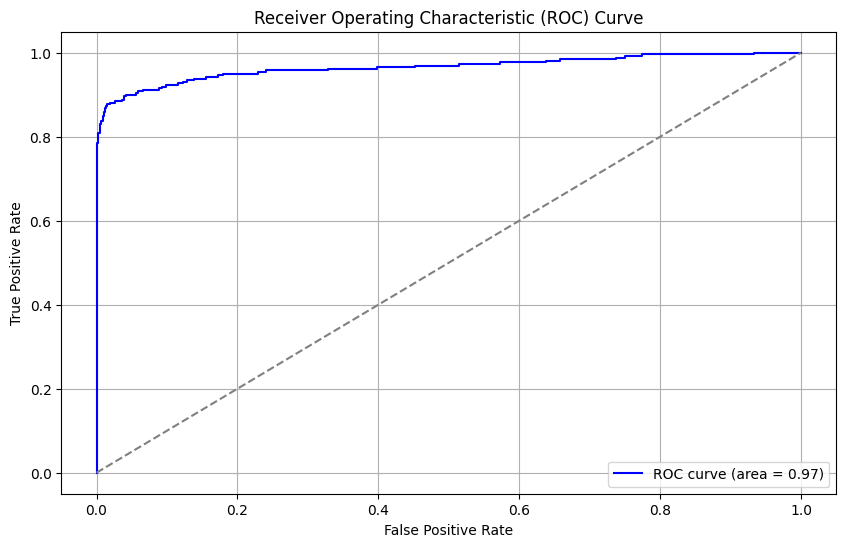

AUC: 0.9650
TPR (Optimal): 0.8808
TNR (Optimal): 0.9815
Optimal Threshold: 0.0025
TPR (TNR = 0.99): 0.8538
Threshold (TNR = 0.99): 0.0028
Total execution time: 372.96s


In [ ]:

import argparse
import json
import math
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
from pathlib import Path
from sklearn.metrics import roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.signal import wiener
from scipy.ndimage import uniform_filter
from numpy.fft import fft2, ifft2
import dtcwt
from dtcwt import Pyramid
#spns_dir = Path("/content/sub_Dresden/sub_Dresden")
spns_dir = Path("/content/drive/MyDrive/ColabUploads/sub_Dresden/sub_Dresden")


memory = joblib.Memory(location='cachedir', verbose=0)

@dataclass
class ImageData:
    image_id: str
    device_id: str

    def spn_path(self):
        device_spns_folder = spns_dir / self.device_id
        return device_spns_folder / (self.image_id + ".JPG")

def read_test_into_image_data_list():
    image_data_list = []

    for device_folder in spns_dir.iterdir():
        if device_folder.is_dir():
            device_id = device_folder.name
            for image_file in device_folder.glob("*.JPG"):
                # Skip hidden files (those that start with a dot)
                if image_file.name.startswith("."):
                    continue
                image_id = image_file.stem
                image_data_list.append(ImageData(image_id=image_id, device_id=device_id))

    return image_data_list


def wiener_adaptive(x: np.ndarray, noise_var: float, **kwargs) -> np.ndarray:

    window_size_list = list(kwargs.pop('window_size_list', [3, 5, 7, 9]))

    if x.ndim == 2:
        energy = x.real ** 2 + x.imag**2
        avg_win_energy = np.zeros(x.shape + (len(window_size_list),))

        for window_idx, window_size in enumerate(window_size_list):
            avg_win_energy[:, :, window_idx] = uniform_filter(energy, window_size, mode='constant')

        coef_var = threshold(avg_win_energy, noise_var)
        coef_var_min = np.min(avg_win_energy, axis=2)
        x = x * noise_var / (coef_var_min + noise_var)

    elif x.ndim == 3:
        out = np.zeros_like(x)
        for ch in range(x.shape[2]):
            out[:, :, ch] = wiener_adaptive(x[:, :, ch], noise_var, **kwargs)
        x = out

    return x


def wiener_dft(im: np.ndarray, sigma: float) -> np.ndarray:

    noise_var = sigma ** 2
    h, w = im.shape

    im_noise_fft = fft2(im)
    im_noise_fft_mag = np.abs(im_noise_fft / (h * w) ** .5)
    im_noise_fft_mag_noise = wiener_adaptive(im_noise_fft_mag, noise_var)

    zeros_y, zeros_x = np.nonzero(im_noise_fft_mag == 0)
    im_noise_fft_mag[zeros_y, zeros_x] = 1
    im_noise_fft_mag_noise[zeros_y, zeros_x] = 0

    im_noise_fft_filt = im_noise_fft * im_noise_fft_mag_noise / im_noise_fft_mag
    im_noise_filt = np.real(ifft2(im_noise_fft_filt))

    return im_noise_filt.astype(np.float32)

def threshold(wlet_coeff_energy_avg: np.ndarray, noise_var: float) -> np.ndarray:

    res = wlet_coeff_energy_avg - noise_var
    return (res + np.abs(res)) / 2

@memory.cache
def get_wave_components(image_path: Path, crop_size=1024, noise_var: float = 1.8**2):
    start_time = time.time()

    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    left = max((width - crop_size) // 2, 0)
    top = max((height - crop_size) // 2, 0)
    right = left + crop_size
    bottom = top + crop_size
    cropped_image = image.crop((left, top, right, bottom))
    image_array = np.array(cropped_image, dtype=np.float32)

    residual_channels = []

    for c in range(3):
        channel = image_array[:, :, c]
        transform = dtcwt.Transform2d()
        coeffs = transform.forward(channel, nlevels=4)

        from dtcwt import Pyramid
        filtered_highpasses = []
        for level in range(4):
            filtered_level = np.zeros_like(coeffs.highpasses[level])
            for direction in range(6):
                filtered_level[:, :, direction] = wiener_adaptive(coeffs.highpasses[level][:, :, direction], noise_var)
            filtered_highpasses.append(filtered_level)

        coeffs = Pyramid(lowpass=np.zeros_like(coeffs.lowpass), highpasses=tuple(filtered_highpasses))
        residual = transform.inverse(coeffs)
        residual_channels.append(residual)

    residual_stack = np.stack(residual_channels, axis=2)

    fingerprint = (
        0.2989 * residual_stack[:, :, 0] +
        0.5870 * residual_stack[:, :, 1] +
        0.1140 * residual_stack[:, :, 2]
    )
    fingerprint = wiener_dft(fingerprint, np.std(fingerprint)).flatten()

    #fingerprint = fingerprint.flatten()
    fingerprint = np.nan_to_num(fingerprint, nan=0.0, posinf=0.0, neginf=0.0)

    extraction_time = time.time() - start_time
    return fingerprint, extraction_time




@memory.cache
def calculate_cosine_similarity(a_path: Path, b_path: Path):
    """
    Computes cosine similarity between two images and tracks comparison time.
    """
    a_pc, a_time = get_wave_components(a_path)
    b_pc, b_time = get_wave_components(b_path)

    start_time = time.time()
    similarity = 1 - cosine(a_pc.ravel(), b_pc.ravel())
    end_time = time.time()

    comparison_time = end_time - start_time
    extraction_time = a_time + b_time  # Sum of both extraction times

    return similarity, extraction_time, comparison_time


def calculate_scores():
    image_data_list = read_test_into_image_data_list()

    fingerprint_dict = {}
    extraction_times = []

    print("Extracting fingerprints...")
    for image_data in tqdm(image_data_list):
        fingerprint, extraction_time = get_wave_components(image_data.spn_path())
        fingerprint_dict[(image_data.device_id, image_data.image_id)] = fingerprint
        extraction_times.append(extraction_time)

    rows = []
    total_comparisons = len(image_data_list) * (len(image_data_list) - 1) // 2
    print(f"Performing {total_comparisons} comparisons...")

    for i, img_data_a in enumerate(tqdm(image_data_list)):
        for img_data_b in image_data_list[i + 1:]:
            fingerprint_a = fingerprint_dict[(img_data_a.device_id, img_data_a.image_id)]
            fingerprint_b = fingerprint_dict[(img_data_b.device_id, img_data_b.image_id)]

            start_time = time.time()
            similarity = 1 - cosine(fingerprint_a, fingerprint_b)
            comparison_time = time.time() - start_time

            rows.append({
                'device_id_1': img_data_a.device_id,
                'image_id_1': img_data_a.image_id,
                'device_id_2': img_data_b.device_id,
                'image_id_2': img_data_b.image_id,
                'similarity': similarity,
                'comparison_time': comparison_time
            })

    df = pd.DataFrame(rows)
    df['avg_extraction_time_per_image'] = np.mean(extraction_times)
    return df


def plot_roc_curve(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def calculate_metrics(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Optimal threshold based on Youden's index (maximizing TPR - FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    tp = ((y_scores >= optimal_threshold) & (y_true == 1)).sum()
    fp = ((y_scores >= optimal_threshold) & (y_true == 0)).sum()
    fn = ((y_scores < optimal_threshold) & (y_true == 1)).sum()
    tn = ((y_scores < optimal_threshold) & (y_true == 0)).sum()

    tpr_optimal = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr_optimal = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Calculate TPR when TNR = 0.99
    desired_tnr = 0.99
    desired_fpr = 1 - desired_tnr

    # Find the closest FPR value to the desired FPR
    idx_tnr = np.where(fpr <= desired_fpr)[0]
    if len(idx_tnr) > 0:
        idx_tnr = idx_tnr[-1]  # Last index where FPR <= desired_fpr
        tpr_at_tnr_99 = tpr[idx_tnr]
        threshold_at_tnr_99 = thresholds[idx_tnr]
    else:
        tpr_at_tnr_99 = 0.0
        threshold_at_tnr_99 = None

    metrics = {
        'AUC': roc_auc,
        'TPR (Optimal)': tpr_optimal,
        'TNR (Optimal)': tnr_optimal,
        'Optimal Threshold': optimal_threshold,
        'TPR (TNR = 0.99)': tpr_at_tnr_99,
        'Threshold (TNR = 0.99)': threshold_at_tnr_99,
    }
    return metrics


def main():
    start = time.time()
    df = calculate_scores()

    avg_extraction_time = df['avg_extraction_time_per_image'].iloc[0]
    avg_comparison_time = df['comparison_time'].mean()

    print(f"Average Fingerprint Extraction Time: {avg_extraction_time:.4f} sec per image")
    print(f"Average Comparison Time: {avg_comparison_time:.4f} sec per comparison")

    plot_roc_curve(df)
    metrics = calculate_metrics(df)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

    end = time.time()
    print(f'Total execution time: {end - start:.2f}s')



if __name__ == '__main__':
    main()


In [ ]:
# gray-WDLAW-DTCWT

Extracting fingerprints...


100%|██████████| 130/130 [03:23<00:00,  1.56s/it]


Performing 8385 comparisons...


100%|██████████| 130/130 [00:30<00:00,  4.29it/s]


Average Fingerprint Extraction Time: 1.5427 sec per image
Average Comparison Time: 0.0036 sec per comparison


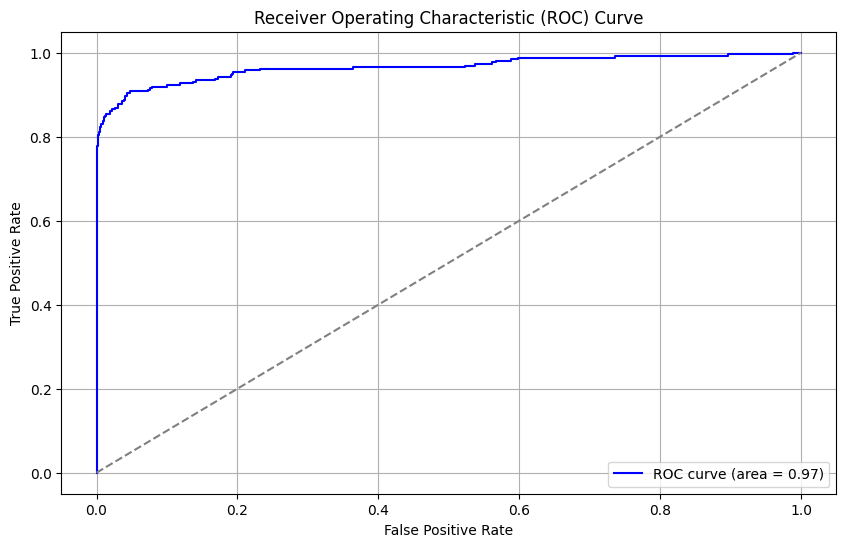

AUC: 0.9652
TPR (Optimal): 0.9038
TNR (Optimal): 0.9563
Optimal Threshold: 0.0022
TPR (TNR = 0.99): 0.8462
Threshold (TNR = 0.99): 0.0030
Total execution time: 233.96s


In [ ]:

import argparse
import json
import math
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
from pathlib import Path
from sklearn.metrics import roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.signal import wiener
from scipy.ndimage import uniform_filter
from numpy.fft import fft2, ifft2
import dtcwt
from dtcwt import Pyramid
#spns_dir = Path("/content/sub_Dresden/sub_Dresden")
spns_dir = Path("/content/drive/MyDrive/ColabUploads/sub_Dresden/sub_Dresden")


memory = joblib.Memory(location='cachedir', verbose=0)

@dataclass
class ImageData:
    image_id: str
    device_id: str

    def spn_path(self):
        device_spns_folder = spns_dir / self.device_id
        return device_spns_folder / (self.image_id + ".JPG")

def read_test_into_image_data_list():
    image_data_list = []

    for device_folder in spns_dir.iterdir():
        if device_folder.is_dir():
            device_id = device_folder.name
            for image_file in device_folder.glob("*.JPG"):
                # Skip hidden files (those that start with a dot)
                if image_file.name.startswith("."):
                    continue
                image_id = image_file.stem
                image_data_list.append(ImageData(image_id=image_id, device_id=device_id))

    return image_data_list


def wiener_adaptive(x: np.ndarray, noise_var: float, **kwargs) -> np.ndarray:

    window_size_list = list(kwargs.pop('window_size_list', [3, 5, 7, 9]))

    if x.ndim == 2:
        energy = x.real ** 2 + x.imag**2
        avg_win_energy = np.zeros(x.shape + (len(window_size_list),))

        for window_idx, window_size in enumerate(window_size_list):
            avg_win_energy[:, :, window_idx] = uniform_filter(energy, window_size, mode='constant')

        coef_var = threshold(avg_win_energy, noise_var)
        coef_var_min = np.min(avg_win_energy, axis=2)
        x = x * noise_var / (coef_var_min + noise_var)

    elif x.ndim == 3:
        out = np.zeros_like(x)
        for ch in range(x.shape[2]):
            out[:, :, ch] = wiener_adaptive(x[:, :, ch], noise_var, **kwargs)
        x = out

    return x


def wiener_dft(im: np.ndarray, sigma: float) -> np.ndarray:

    noise_var = sigma ** 2
    h, w = im.shape

    im_noise_fft = fft2(im)
    im_noise_fft_mag = np.abs(im_noise_fft / (h * w) ** .5)
    im_noise_fft_mag_noise = wiener_adaptive(im_noise_fft_mag, noise_var)

    zeros_y, zeros_x = np.nonzero(im_noise_fft_mag == 0)
    im_noise_fft_mag[zeros_y, zeros_x] = 1
    im_noise_fft_mag_noise[zeros_y, zeros_x] = 0

    im_noise_fft_filt = im_noise_fft * im_noise_fft_mag_noise / im_noise_fft_mag
    im_noise_filt = np.real(ifft2(im_noise_fft_filt))

    return im_noise_filt.astype(np.float32)

def threshold(wlet_coeff_energy_avg: np.ndarray, noise_var: float) -> np.ndarray:

    res = wlet_coeff_energy_avg - noise_var
    return (res + np.abs(res)) / 2

@memory.cache
def get_wave_components(image_path: Path, crop_size=1024, noise_var: float = 1.8**2):
    start_time = time.time()

    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    left = max((width - crop_size) // 2, 0)
    top = max((height - crop_size) // 2, 0)
    right = left + crop_size
    bottom = top + crop_size
    cropped_image = image.crop((left, top, right, bottom))
    image_array = np.array(cropped_image, dtype=np.float32)

    # Convert to grayscale
    grayscale_image = (
        0.2989 * image_array[:, :, 0] +
        0.5870 * image_array[:, :, 1] +
        0.1140 * image_array[:, :, 2]
    )

    transform = dtcwt.Transform2d()
    coeffs = transform.forward(grayscale_image, nlevels=4)

    fingerprint_parts = []
    for level in range(4):
        for direction in range(6):
            subband = coeffs.highpasses[level][:, :, direction]
            filtered_subband = wiener_adaptive(subband, noise_var)

            filtered_subband = wiener_dft(filtered_subband, np.std(filtered_subband))

            fingerprint_parts.append(filtered_subband.flatten())

    fingerprint = np.concatenate(fingerprint_parts).astype(np.float32)
    extraction_time = time.time() - start_time
    return fingerprint, extraction_time



@memory.cache
def calculate_cosine_similarity(a_path: Path, b_path: Path):
    """
    Computes cosine similarity between two images and tracks comparison time.
    """
    a_pc, a_time = get_wave_components(a_path)
    b_pc, b_time = get_wave_components(b_path)

    start_time = time.time()
    similarity = 1 - cosine(a_pc.ravel(), b_pc.ravel())
    end_time = time.time()

    comparison_time = end_time - start_time
    extraction_time = a_time + b_time  # Sum of both extraction times

    return similarity, extraction_time, comparison_time


def calculate_scores():
    image_data_list = read_test_into_image_data_list()

    fingerprint_dict = {}
    extraction_times = []

    print("Extracting fingerprints...")
    for image_data in tqdm(image_data_list):
        fingerprint, extraction_time = get_wave_components(image_data.spn_path())
        fingerprint_dict[(image_data.device_id, image_data.image_id)] = fingerprint
        extraction_times.append(extraction_time)

    rows = []
    total_comparisons = len(image_data_list) * (len(image_data_list) - 1) // 2
    print(f"Performing {total_comparisons} comparisons...")

    for i, img_data_a in enumerate(tqdm(image_data_list)):
        for img_data_b in image_data_list[i + 1:]:
            fingerprint_a = fingerprint_dict[(img_data_a.device_id, img_data_a.image_id)]
            fingerprint_b = fingerprint_dict[(img_data_b.device_id, img_data_b.image_id)]

            start_time = time.time()
            similarity = 1 - cosine(fingerprint_a, fingerprint_b)
            comparison_time = time.time() - start_time

            rows.append({
                'device_id_1': img_data_a.device_id,
                'image_id_1': img_data_a.image_id,
                'device_id_2': img_data_b.device_id,
                'image_id_2': img_data_b.image_id,
                'similarity': similarity,
                'comparison_time': comparison_time
            })

    df = pd.DataFrame(rows)
    df['avg_extraction_time_per_image'] = np.mean(extraction_times)
    return df


def plot_roc_curve(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def calculate_metrics(df):
    df['label'] = (df['device_id_1'] == df['device_id_2']).astype(int)
    y_true = df['label'].values
    y_scores = df['similarity'].values

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Optimal threshold based on Youden's index (maximizing TPR - FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    tp = ((y_scores >= optimal_threshold) & (y_true == 1)).sum()
    fp = ((y_scores >= optimal_threshold) & (y_true == 0)).sum()
    fn = ((y_scores < optimal_threshold) & (y_true == 1)).sum()
    tn = ((y_scores < optimal_threshold) & (y_true == 0)).sum()

    tpr_optimal = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr_optimal = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Calculate TPR when TNR = 0.99
    desired_tnr = 0.99
    desired_fpr = 1 - desired_tnr

    # Find the closest FPR value to the desired FPR
    idx_tnr = np.where(fpr <= desired_fpr)[0]
    if len(idx_tnr) > 0:
        idx_tnr = idx_tnr[-1]  # Last index where FPR <= desired_fpr
        tpr_at_tnr_99 = tpr[idx_tnr]
        threshold_at_tnr_99 = thresholds[idx_tnr]
    else:
        tpr_at_tnr_99 = 0.0
        threshold_at_tnr_99 = None

    metrics = {
        'AUC': roc_auc,
        'TPR (Optimal)': tpr_optimal,
        'TNR (Optimal)': tnr_optimal,
        'Optimal Threshold': optimal_threshold,
        'TPR (TNR = 0.99)': tpr_at_tnr_99,
        'Threshold (TNR = 0.99)': threshold_at_tnr_99,
    }
    return metrics


def main():
    start = time.time()
    df = calculate_scores()

    avg_extraction_time = df['avg_extraction_time_per_image'].iloc[0]
    avg_comparison_time = df['comparison_time'].mean()

    print(f"Average Fingerprint Extraction Time: {avg_extraction_time:.4f} sec per image")
    print(f"Average Comparison Time: {avg_comparison_time:.4f} sec per comparison")

    plot_roc_curve(df)
    metrics = calculate_metrics(df)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

    end = time.time()
    print(f'Total execution time: {end - start:.2f}s')



if __name__ == '__main__':
    main()
